<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/no_shows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install category_encoders==2.*
!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)
df = tools.fixTarget(df)

X = df.drop('reservation_status', axis=1)
y= df['reservation_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2,
                                                  random_state=42, stratify=y_train)


     |████████████████████████████████| 81kB 2.2MB/s 
--2020-06-08 03:12:47--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8279 (8.1K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]   8.08K  --.-KB/s    in 0s      

2020-06-08 03:12:47 (63.6 MB/s) - ‘tools.py’ saved [8279/8279]



In [0]:
w = tools.wrangleData(max_cardinality=50)
w.transform(X_train).describe()

,lead_time,arrival_date_week_number,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,nights_stay
count,66858.000000,66858.000000,66852.000000,66858.000000,66858.000000,66858.000000,66858.000000,66858.000000,66858.000000,66858.000000,60195.000000,66858.000000,66858.000000,66446.000000
mean,104.136693,27.136738,1.851822,0.104625,0.007897,0.032203,0.092270,0.137994,0.219630,2.354378,108.692020,0.062341,0.568698,3.452533
std,107.154489,13.618130,0.488888,0.399327,0.090356,0.176539,0.899481,1.508495,0.651676,17.702183,42.799289,0.244422,0.790979,2.589820
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,1.000000
25%,18.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.500000,0.000000,0.000000,2.000000
50%,69.000000,27.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000,3.000000
75%,161.000000,38.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,130.000000,0.000000,1.000000,4.000000
max,709.000000,53.000000,4.000000,3.000000,2.000000,1.000000,26.000000,72.000000,21.000000,391.000000,300.000000,8.000000,5.000000,57.000000


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

In [0]:
log = make_pipeline(tools.wrangleData(max_cardinality=50),
                    ce.OrdinalEncoder(),
                    SimpleImputer(),
                    LogisticRegression(max_iter=5000))

tools.tryModel(log, X_train, y_train, X_val, y_val)



Train score = 79.36821322803553 %
Validate score = 79.60514507927012 %




'Confusion Matrix'

,Check-Out,Canceled,No-Show
Check-Out,9846,578,1
Canceled,2568,3454,0
No-Show,243,19,6


'Metrics'

,precision,recall,f1-score
Check-Out,0.777909,0.944460,0.853132
Canceled,0.852629,0.573564,0.685794
No-Show,0.857143,0.022388,0.043636


In [0]:
pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestClassifier(random_state=42))

tools.tryModel(pipeline, X_train, y_train, X_val, y_val)



Train score = 99.23419785216429 %
Validate score = 85.55189949147473 %




'Confusion Matrix'

,Check-Out,Canceled,No-Show
Check-Out,9620,795,10
Canceled,1430,4585,7
No-Show,146,27,95


'Metrics'

,precision,recall,f1-score
Check-Out,0.859235,0.922782,0.889876
Canceled,0.847975,0.761375,0.802345
No-Show,0.848214,0.354478,0.500000


In [0]:
import matplotlib.pyplot as plt
def plotFeatures(pipeline):
    model = pipeline.named_steps['randomforestclassifier']
    wrangler = pipeline.named_steps['wrangledata']
    importances = pd.Series(model.feature_importances_, wrangler.columns_)
    plt.figure(figsize=(10, len(wrangler.columns_) / 2))
    importances.sort_values().plot.barh();

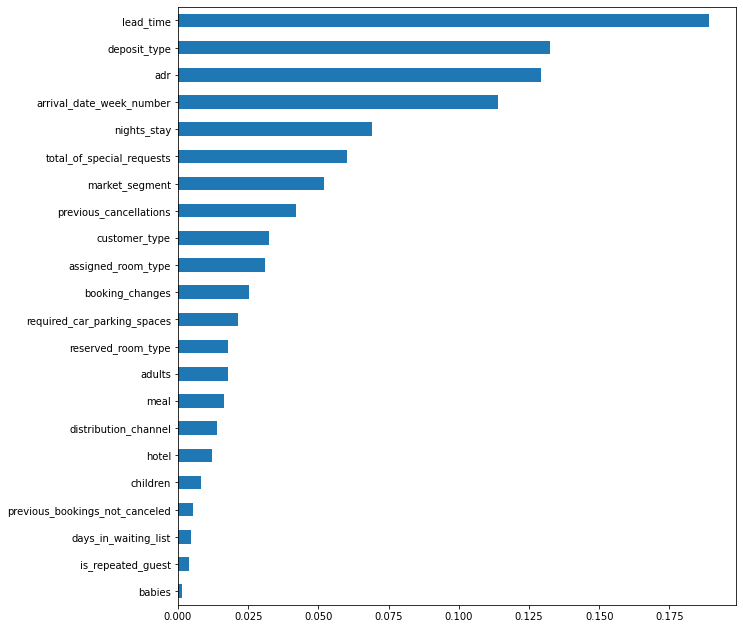

In [0]:
plotFeatures(pipeline)

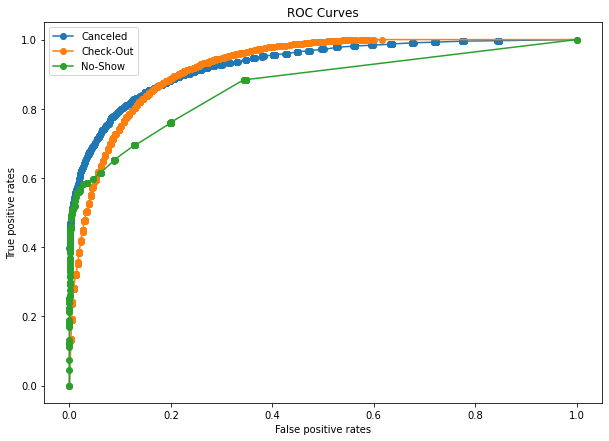

In [0]:
model = pipeline.named_steps['randomforestclassifier']
tools.ROCcurves(y_val, X_val, pipeline, model.classes_)

In [0]:
pipeline1 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         SMOTE(random_state=42),
                         RandomForestClassifier(random_state=42))

tools.tryModel(pipeline1, X_train, y_train, X_val, y_val)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.19231804720452 %
Validate score = 85.38438528268023 %




'Confusion Matrix'

,Check-Out,Canceled,No-Show
Check-Out,9547,859,19
Canceled,1402,4609,11
No-Show,123,29,116


'Metrics'

,precision,recall,f1-score
Check-Out,0.862265,0.915779,0.888217
Canceled,0.838457,0.765360,0.800243
No-Show,0.794521,0.432836,0.560386


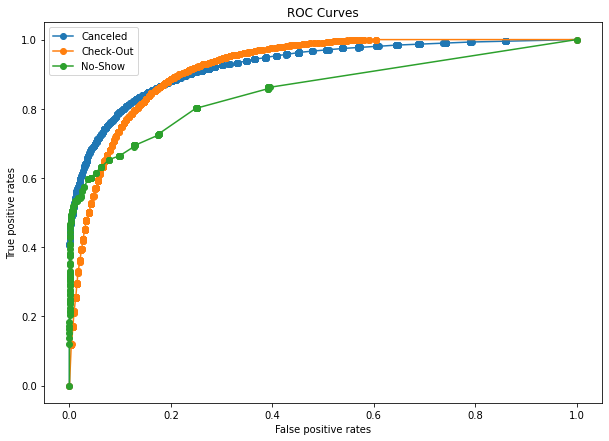

In [0]:
model = pipeline1.named_steps['randomforestclassifier']
tools.ROCcurves(y_val, X_val, pipeline1, model.classes_)

In [0]:
y_train_ns = y_train == 'No-Show'
y_val_ns = y_val == 'No-Show'

y_val_ns.value_counts()

False    16447
True       268
Name: reservation_status, dtype: int64

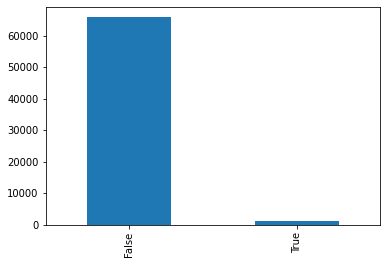

In [0]:
y_train_ns.value_counts().plot.bar();

In [0]:
sum(y_train_ns) / len(y_train_ns)

0.016019025397110292

In [0]:
from sklearn.dummy import DummyClassifier

baseline = make_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         DummyClassifier(strategy='most_frequent')
                         )

tools.tryModel(baseline, X_train, y_train_ns, X_val, y_val_ns)



Train score = 98.39809746028897 %
Validate score = 98.39664971582411 %




/content/tools.py:171: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[i][i] / pred_sums[i]


'Confusion Matrix'

,False,True
False,16447,0
True,268,0


'Metrics'

,precision,recall,f1-score
False,0.983966,1.0,0.991918
True,NaN,0.0,NaN


In [0]:
tools.tryModel(pipeline, X_train, y_train_ns, X_val, y_val_ns)



Train score = 99.93269317060037 %
Validate score = 99.0667065510021 %




'Confusion Matrix'

,False,True
False,16436,11
True,145,123


'Metrics'

,precision,recall,f1-score
False,0.991255,0.999331,0.995277
True,0.917910,0.458955,0.611940


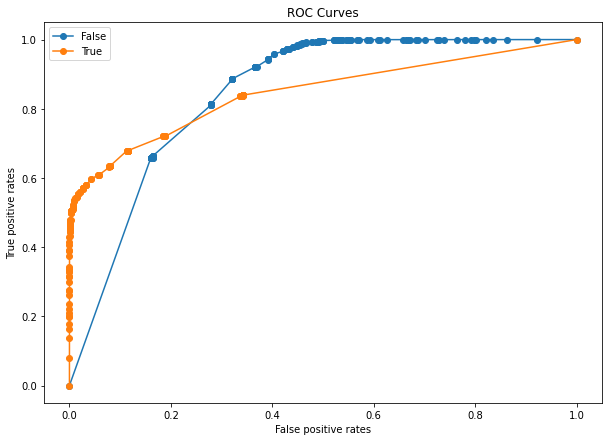

In [0]:
model = pipeline.named_steps['randomforestclassifier']
tools.ROCcurves(y_val_ns, X_val, pipeline, model.classes_)

In [0]:
features = ['lead_time', 'nights_stay', 'previous_cancellations', 'deposit_type']

pipeline2 = make_imb_pipeline(tools.wrangleData(),
                          tools.selectFeatures(features),
                          ce.OrdinalEncoder(),
                          SimpleImputer(),
                          SMOTE(random_state=42),
                          RandomForestClassifier(random_state=42,
                                                 n_jobs=-1))

tools.tryModel(pipeline2, X_train, y_train_ns, X_val, y_val_ns)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 92.07424691136438 %
Validate score = 91.98324857912054 %




'Confusion Matrix'

,False,True
False,15228,1219
True,121,147


'Metrics'

,precision,recall,f1-score
False,0.992117,0.925883,0.957856
True,0.107613,0.548507,0.179927


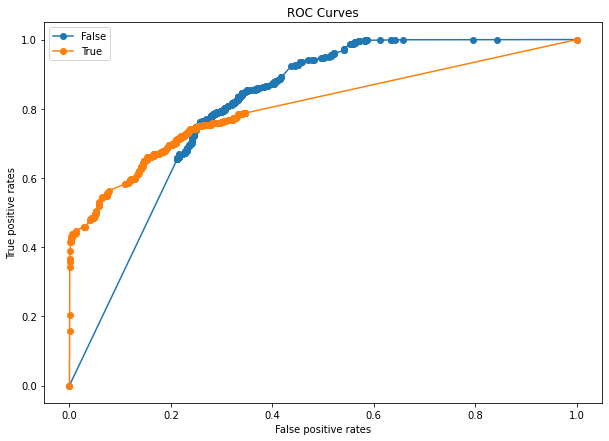

In [0]:
model = pipeline2.named_steps['randomforestclassifier']
tools.ROCcurves(y_val_ns, X_val, pipeline2, model.classes_)

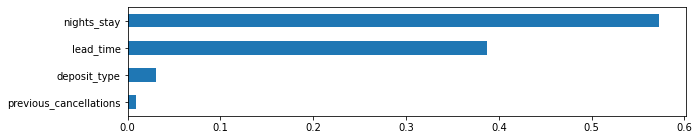

In [0]:
model = pipeline2.named_steps['randomforestclassifier']
selector = pipeline2.named_steps['selectfeatures']
importances = pd.Series(model.feature_importances_, selector.features)
plt.figure(figsize=(10, len(selector.features) / 2))
importances.sort_values().plot.barh();

In [0]:
pipeline3 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                              tools.selectFeatures(features),
                              ce.OrdinalEncoder(),
                              SimpleImputer(),
                              SMOTE(random_state=42),
                              RandomForestClassifier(random_state=42,
                                                     n_jobs=-1))

params = {'randomforestclassifier__max_depth': range(10, 50, 100),
          'randomforestclassifier__n_estimators': [50, 100, 150, 200],
          'randomforestclassifier__min_samples_split': [2, 4, 8, 10],
          'randomforestclassifier__min_samples_leaf': [2, 4, 8, 10]}
search = GridSearchCV(pipeline3, params, n_jobs=-1, cv=3, scoring='recall',
                      verbose=10)
search.fit(X_train, y_train_ns)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 11

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('wrangledata',
                                        wrangleData(max_cardinality=50,
                                                    remove_dates=True)),
                                       ('selectfeatures',
                                        selectFeatures(features=['lead_time',
                                                                 'stays_in_week_nights',
                                                                 'previous_cancellations',
                                                                 'deposit_type'])),
                                       ('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                       

In [0]:
search.best_score_

0.5555555555555557

In [0]:
search.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 50}

In [0]:
pipeline4 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                              tools.selectFeatures(features),
                              ce.OrdinalEncoder(),
                              SimpleImputer(),
                              SMOTE(random_state=42),
                              RandomForestClassifier(random_state=42,
                                                     n_jobs=-1,
                                                     max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=2,
                                                     n_estimators=50))
tools.tryModel(pipeline4, X_train, y_train_ns, X_val, y_val_ns)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 89.46573334529899 %
Validate score = 89.61411905474125 %




'Confusion Matrix'

,False,True
False,14837,1610
True,126,142


'Metrics'

,precision,recall,f1-score
False,0.991579,0.902110,0.944731
True,0.081050,0.529851,0.140594


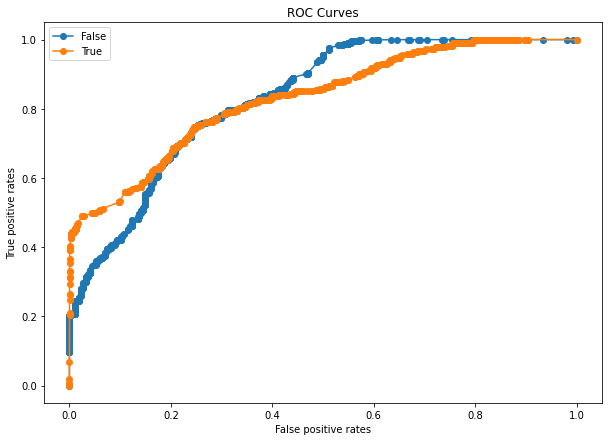

In [0]:
model = pipeline4.named_steps['randomforestclassifier']
tools.ROCcurves(y_val_ns, X_val, pipeline4, model.classes_)

In [0]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', y_train_ns.unique(), y_train_ns)
weights

array([ 0.50813991, 31.21288515])

In [0]:
pipeline5 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                              tools.selectFeatures(features),
                              ce.OrdinalEncoder(),
                              SimpleImputer(),
                              SMOTE(random_state=42),
                              RandomForestClassifier(random_state=42,
                                                     n_jobs=-1,
                                                     max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=2,
                                                     n_estimators=50,
                                                     class_weight={False:weights[0], 
                                                                   True:weights[1]}))
tools.tryModel(pipeline5, X_train, y_train_ns, X_val, y_val_ns)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 23.77127643662688 %
Validate score = 23.876757403529762 %




'Confusion Matrix'

,False,True
False,3723,12724
True,0,268


'Metrics'

,precision,recall,f1-score
False,1.000000,0.226363,0.369162
True,0.020628,1.000000,0.040422


In [0]:
from sklearn.metrics import precision_score, recall_score
y_pred = pipeline5.predict(X_val)
print(f'Precision {precision_score(y_val_ns, y_pred) * 100} %')
print(f'Recall {recall_score(y_val_ns, y_pred) * 100} %')

Precision 2.062807881773399 %
Recall 100.0 %


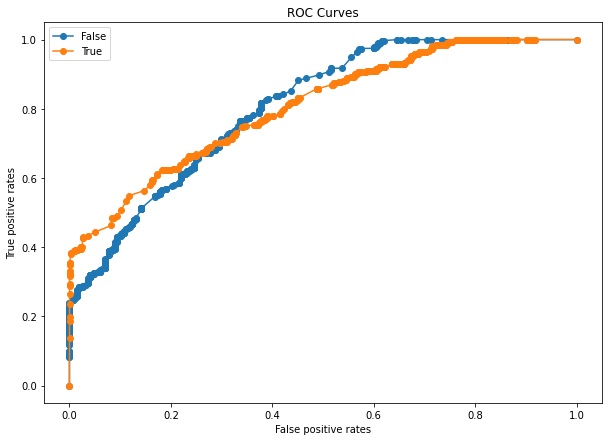

In [0]:
model = pipeline5.named_steps['randomforestclassifier']
tools.ROCcurves(y_val_ns, X_val, pipeline5, model.classes_)